In [1]:
"""
Determines the most likely home and work locations for each user ID.
Where home/work locations are census tracts.
"""

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from util import get_shapefile_filename, get_shapefile_filepath


In [2]:
# Define columns as variables
DEVICE_ID = 'device ID'
DAY = 'day'
DWELLTIME = 'DwellTime'
TIMESTAMP = 'timestamp'

TRACT = 'TRACT'

# The columns this script adds
NIGHTTIME_DWELLTIME = 'nighttime dwelltime'
DAYTIME_DWELLTIME = 'daytime dwelltime'

HOME_TRACT = 'home TRACT'
WORK_TRACT = 'work TRACT'


The following data processing is for Middlesex, Norfolk, Suffolk counties,
for a 2 week period, containing users with a threshold number of unique days and nights of data.

- Middlesex county (017) population Estimate (2018) 1,614,714; Source: https://en.wikipedia.org/wiki/Middlesex_County,_Massachusetts
- Norfolk (021) county population Estimate (2018) 705,388; Source: https://en.wikipedia.org/wiki/Norfolk_County,_Massachusetts
- Suffolk county (025) population Estimate (2018) 807,252; Source: https://en.wikipedia.org/wiki/Suffolk_County,_Massachusetts

Combined population estimate: 3,127,354 


In [3]:
counties = ['middlesex', 'norfolk', 'suffolk']
input_filepath = './data/mount/201805/filtered/20180507_20180511/county_middlesex_norfolk_suffolk_3days_3nights.csv'
# input_filepath = 'data/mount/201805/filtered/20180500_20180514/county_middlesex_norfolk_suffolk_7days_6nights.csv'


counties_combined_population_estimate = 1614714 + 705388 + 807252
print('Combined population estimate:', counties_combined_population_estimate)

Combined population estimate: 3127354


In [6]:
df = pd.read_csv(input_filepath)
# update the columns to use 'device ID instead of LBS provider name'
df.rename(columns={df.columns[2]:DEVICE_ID}, inplace=True)

print('data rows: ', df.shape[0])
user_count = df[DEVICE_ID].nunique()
print('users count', user_count)
print('sample percentage = (users count)/(population estimate)*100 = (%s/%s)*100 = %s' % (
        user_count, counties_combined_population_estimate, (user_count/counties_combined_population_estimate)*100))

data rows:  524810
users count 22705
sample percentage = (users count)/(population estimate)*100 = (22705/3127354)*100 = 0.726013108845369



- Define nighttime and daytime hours.
- Dwell points during nighttime hours are used to compute likely home areas.
- Dwell points during daytime hours are used to compute likely work areas.

To do this we
- Add columns to each dwell point representing the portion of the dwell that occurred in the nighttime and daytime.
  - i.e. 'nighttime dwelltime' counts minutes of dwell that occurred in the nighttime.
  - 'daytime dwelltime' counts minutes of dwell that occurred in the daytime.



In [7]:
# Define nighttime and daytime hours.

# 8pm to 9am
NIGHTTIME_STARTHOUR = 20
NIGHTTIME_ENDHOUR = 9

# 9am to 8pm
DAYTIME_STARTHOUR = 9
DAYTIME_ENDHOUR = 20


In [8]:
"""
Notes on Working with timestamps:
The timestamps are in ISO format.  e.g. '2018-05-01T07:18:02-04:00'
The offset refers to how many hours the timezone is from Coordinated Universal Time (UTC).
"""
from datetime import datetime, timedelta
from dateutil import tz, parser


def timedelta_minutes(tdelta):
    """Helper function. Returns minutes for timedelta object."""
    return round((tdelta.seconds / 60), 2)


def get_nighttime_dwelltime(row):
    """Returns the portion of the dwelltime that occurred in the nighttime hours."""
    dwelltime = timedelta(minutes=float(row[DWELLTIME]))
    dwell_start = parser.parse(str(row[TIMESTAMP]))
    dwell_starthour = dwell_start.time().hour
    dwell_end = dwell_start + dwelltime
    dwell_endhour = dwell_end.time().hour
    # Return zero for dwelltimes that do not overlap with the nighttime hours.
    if (dwell_starthour >= NIGHTTIME_ENDHOUR) \
        and (dwell_starthour < NIGHTTIME_STARTHOUR) \
        and (dwell_endhour < NIGHTTIME_STARTHOUR) \
        and (dwell_endhour >= NIGHTTIME_ENDHOUR):
        return 0
    
    if (dwell_starthour < NIGHTTIME_ENDHOUR):
        # dwelltime starts in the early hours of the morning, before nighttime ends.
        # restrict the dwelltime to the nighttime hours
        nighttime_end_dt = datetime(dwell_start.year,  dwell_start.month, dwell_start.day, hour=NIGHTTIME_ENDHOUR, tzinfo=dwell_start.tzinfo)
        nighttime_dwelltime = min((nighttime_end_dt - dwell_start), dwelltime)
    
    else: # otherwise... the dwelltime starts before midnight
        nighttime_dwelltime = dwelltime
        # if it start before the nighttime starts, subtract the portion before nighttime starts
        nighttime_start_dt = datetime(dwell_start.year,  dwell_start.month, dwell_start.day, hour=NIGHTTIME_STARTHOUR, tzinfo=dwell_start.tzinfo)
        if dwell_start < nighttime_start_dt:
            delta = nighttime_start_dt - dwell_start
            nighttime_dwelltime -= delta
        
        # if the dwell continues until the next day, and
        # if the dwell ends after the nighttime ends,
        # then subtract the portion that happens after nighttime ends
        if ((dwell_endhour < NIGHTTIME_STARTHOUR) and (dwell_endhour > NIGHTTIME_ENDHOUR)):
            # the nighttime end for this case is the next day
            nighttime_end_dt = datetime(dwell_end.year,  dwell_end.month, dwell_end.day, hour=NIGHTTIME_ENDHOUR, tzinfo=dwell_end.tzinfo)
            delta = dwell_end - nighttime_end_dt
            nighttime_dwelltime -= delta
    return timedelta_minutes(nighttime_dwelltime)


In [9]:
# Add the nighttime dwelltime
df[NIGHTTIME_DWELLTIME] = df[[DEVICE_ID, TIMESTAMP, DWELLTIME]].apply(get_nighttime_dwelltime, axis=1)
# The daytime dwelltime is simply the dwelltime less the nighttime dwelltime
df[DAYTIME_DWELLTIME] = df[DWELLTIME] - df[NIGHTTIME_DWELLTIME]

## Assigning likely homes

Next we aggregate dwelltimes for each area in which dwells occur to assign likely home areas.
However, before doing so, we inspect where people live according to the American Community Survey (ACS).

- Identify and inspect areas with very low populations.
- If appropriate, remove these areas as eligible places for the LBS users to have homes.

This is done iteratively, with correlation between LBS users & ACS population estimates considered each time.

In [10]:
# Load in the ACS estimates data, join it with tracts shapefile, and map the data.

user_data_tracts = df[TRACT].unique()

# Load in and prepare the ACS data
acs_census_tract_population_est_data_filepath = './data/ACS/ma_acs_5_year_census_tract_2017/ACS_17_5YR_B01003_with_ann.csv'
acs_census_tract_population_est_df = pd.read_csv(acs_census_tract_population_est_data_filepath)
acs_census_tract_population_est_df.drop(labels=['Id'],axis=1,inplace=True)
acs_census_tract_population_est_df.rename(columns={'Id2':TRACT},inplace=True)
print('all tracts for MA: %s, user dwell tracts: %s' % (acs_census_tract_population_est_df.shape[0], len(user_data_tracts)))
# Filter this dataset to just our user's home tracts
acs_census_tract_population_est_df = acs_census_tract_population_est_df[acs_census_tract_population_est_df[TRACT].isin(user_data_tracts)]
assert(acs_census_tract_population_est_df.shape[0] == len(user_data_tracts))
acs_census_tract_population_est_df.head(3)

all tracts for MA: 1478, user dwell tracts: 651


,TRACT,Geography,Estimate; Total,Margin of Error; Total
547,25017300100,"Census Tract 3001, Middlesex County, Massachus...",3195,25
548,25017301101,"Census Tract 3011.01, Middlesex County, Massac...",4097,193
549,25017301102,"Census Tract 3011.02, Middlesex County, Massac...",5321,191


/Users/aberke/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,geometry,Geography,Estimate; Total,Margin of Error; Total
TRACT,,,,
25025981000,POLYGON ((-71.11766160617178 42.30256166076779...,"Census Tract 9810, Suffolk County, Massachusetts",0.0,12.0
25025981700,POLYGON ((-71.06456259253244 42.35239167199428...,"Census Tract 9817, Suffolk County, Massachusetts",0.0,12.0
25025981600,(POLYGON ((-70.99495057144142 42.3925576814935...,"Census Tract 9816, Suffolk County, Massachusetts",0.0,12.0
25025981501,(POLYGON ((-71.1277596138725 42.37306367347855...,"Census Tract 9815.01, Suffolk County, Massachu...",0.0,12.0
25025981201,"(POLYGON ((-71.0186875757371 42.3387756705654,...","Census Tract 9812.01, Suffolk County, Massachu...",0.0,12.0
25017980000,POLYGON ((-71.46945272777883 42.40263966821112...,"Census Tract 9800, Middlesex County, Massachus...",0.0,12.0
25025980700,POLYGON ((-71.14065361224276 42.27518765464881...,"Census Tract 9807, Suffolk County, Massachusetts",8.0,11.0
25025981502,"POLYGON ((-71.00271257481467 42.4044006832574,...","Census Tract 9815.02, Suffolk County, Massachu...",12.0,12.0


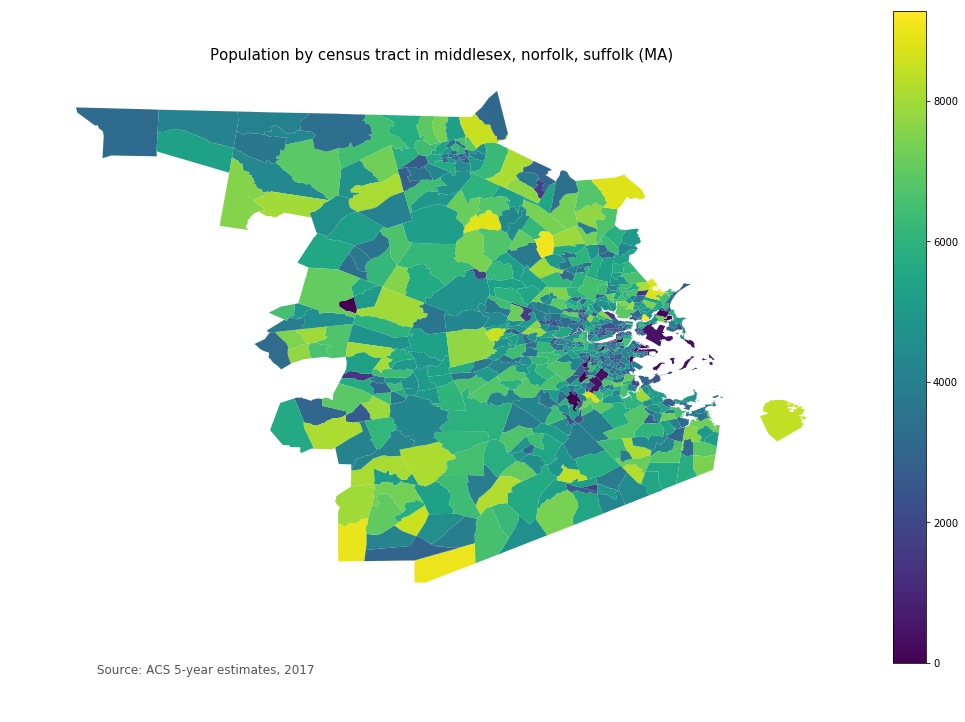

In [20]:
# Read in the census tracts shapefile,
# make the columns and values like the ACS data, then merge with ACS population data

ACS_POPULATION_ESTIMATE = "Estimate; Total"
GEOMETRY = 'geometry'

# Read in the shapefile and merge it with the ACS data
tracts_shapefile_filepath = get_shapefile_filepath('ma', 'tract', counties)
tracts_shapefile = gpd.read_file(tracts_shapefile_filepath).to_crs(epsg=4326)[['GEOID10', GEOMETRY]].rename(columns={'GEOID10': TRACT})
tracts_shapefile[TRACT] = tracts_shapefile.astype({TRACT: 'int64'})[TRACT]
merged_tracts_data_shapefile = tracts_shapefile.set_index(TRACT).join(acs_census_tract_population_est_df.set_index(TRACT))

# Make the population map!
fig, ax = plt.subplots(1, figsize=(18, 12))
merged_tracts_data_shapefile.plot(column=ACS_POPULATION_ESTIMATE, legend=True, ax=ax) #, cmap='Blues', linewidth=0.8, edgecolor='0.8')
ax.axis('off')
title = 'Population by census tract in %s (MA)' % ', '.join(counties)
ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'})
# create an annotation for the data source
annotation = 'Source: ACS 5-year estimates, 2017'
ax.annotate(annotation, xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

merged_tracts_data_shapefile.sort_values(by=[ACS_POPULATION_ESTIMATE]).head(8)

In [21]:
# Goal: Better understand this population data...
print('Distribution of per tract population estimates (source: ACS 2017)')
merged_tracts_data_shapefile[ACS_POPULATION_ESTIMATE].describe()

Distribution of per tract population estimates (source: ACS 2017)


count     651.000000
mean     4697.173579
std      1806.989402
min         0.000000
25%      3347.000000
50%      4659.000000
75%      5944.000000
max      9286.000000
Name: Estimate; Total, dtype: float64

### Data notes

There are census tracts that have an estimated population of 0!  These include the airport and should be removed from the dataset.

Tracts with population estimates of 0:
- tract 25025981700 is the Boston Common + public gardens
- tract 25025981501 is a squiggle along the Charles river from Boston's Longfellow bridge to Newton (why make that a tract?)
- tract 25025981201 is another weird squiggle along the water and parkland in Boston by Castle Island
- nextdoor is tract 25025981202 (population est = 224) in an industrial area
- tract 25025981502 (pop est = 12) is over parks and highways
- tract 25025980300 (pop est = 365) mainly covers Franklin Park & Franklin Zoo
- tract 25025981100 (population estimate = 409) mainly covers cemeteries (Forest Hills, Mount Hope cemeteries)


In [22]:
# Get the tracts where the ACS estimates are small
# Too small: < 500 people
ELIGIBLE_HOME_TRACT_POP_THRESHOLD = 500
ineligible_home_tracts = merged_tracts_data_shapefile[merged_tracts_data_shapefile[ACS_POPULATION_ESTIMATE] < ELIGIBLE_HOME_TRACT_POP_THRESHOLD].index.values
ineligible_home_tracts

array([25025980300, 25025981600, 25025981300, 25025981201, 25025981501,
       25025981700, 25025981800, 25025981202, 25025981100, 25025980700,
       25025980101, 25025981502, 25025981000, 25017980000])

In [23]:
"""Infer home area (census tract).
Where inferred home area for a user is where they spend the most nighttime dwelltime.

Create a mapping of userID -> inferred home census tract.
This will be a dataframe with columns: DEVICE_ID, HOME_TRACT

To do so...
create a dictionary mapping userID -> home tract

then transform dictionary into a DF.
"""

inferred_homes_map = {} # Maps userID -> home area

night_df = df[df[NIGHTTIME_DWELLTIME] > 0]

user_ids = df[DEVICE_ID].unique()
for i, user_id in np.ndenumerate(user_ids):
    if (i[0] % 1000) == 0:
        print('inferring home for user', i[0], datetime.now())
    # Make map for user as {tract: cumulative dwelltime, for each tract they have been in the night}
    # but exclude the ineligible home tracts
    user_map = {}
    # Get the mapping of tract to dwelltimes for given user
    user_night_df = night_df[(night_df[DEVICE_ID] == user_id)][[TRACT, NIGHTTIME_DWELLTIME]]
    user_night_tracts = user_night_df[TRACT].unique()
    for tract in user_night_tracts:
        if tract in ineligible_home_tracts:
            continue
        tract_nighttime_dwelltime = user_night_df[user_night_df[TRACT] == tract][NIGHTTIME_DWELLTIME].sum()
        user_map[tract] = tract_nighttime_dwelltime
    # choose the tract with the greatest dwelltime as inferred home tract
    max_dwelltime = 0
    max_dwelltime_tract = None
    for tract, nighttime_dwelltime in user_map.items():
        if nighttime_dwelltime > max_dwelltime:
            max_dwelltime = nighttime_dwelltime
            max_dwelltime_tract = tract
        
    inferred_homes_map[user_id] = max_dwelltime_tract

print("made inferred homes map for %s users" % len(inferred_homes_map))


inferring home for user 0 2019-12-08 09:25:57.552801
inferring home for user 1000 2019-12-08 09:26:18.516755
inferring home for user 2000 2019-12-08 09:26:39.071279
inferring home for user 3000 2019-12-08 09:26:59.954703
inferring home for user 4000 2019-12-08 09:27:20.441143
inferring home for user 5000 2019-12-08 09:27:40.630641
inferring home for user 6000 2019-12-08 09:28:00.677409
inferring home for user 7000 2019-12-08 09:28:21.954536
inferring home for user 8000 2019-12-08 09:28:41.784877
inferring home for user 9000 2019-12-08 09:29:01.149468
inferring home for user 10000 2019-12-08 09:29:20.494298
inferring home for user 11000 2019-12-08 09:29:39.680127
inferring home for user 12000 2019-12-08 09:29:58.916510
inferring home for user 13000 2019-12-08 09:30:18.217539
inferring home for user 14000 2019-12-08 09:30:37.434249
inferring home for user 15000 2019-12-08 09:30:56.555306
inferring home for user 16000 2019-12-08 09:31:15.636591
inferring home for user 17000 2019-12-08 09:

In [ ]:
# Transform the user -> tract dictionary into a dataframe
user_homes_df = pd.DataFrame.from_dict({DEVICE_ID: list(inferred_homes_map.keys()),
                                        HOME_TRACT: list(inferred_homes_map.values())})
print('rows:', user_homes_df.shape[0])
print('unique home tracts:', user_homes_df[HOME_TRACT].nunique())
assert(user_homes_df[DEVICE_ID].nunique() == user_homes_df.shape[0])
user_homes_df.head()

In [ ]:
# Are there any uses who were not assigned homes? Yes.. TODO: Deal with this better
na_user_homes = user_homes_df[user_homes_df.isnull().any(axis=1)]
print('dropping %s users without identified tracts -- TODO: handle this better?' % na_user_homes.shape[0])
user_homes_df.dropna(inplace=True)
na_user_homes.head(10)

In [26]:
# Aggregate to mapping: home TRACT --> user count
USER_COUNT = 'LBS user count'

# Create dictionary, then dataframe
home_tracts_to_users_dict = {} # {TRACT: user count}

home_tracts = user_homes_df[HOME_TRACT].unique()
for tract in home_tracts:
    user_count = user_homes_df[user_homes_df[HOME_TRACT]==tract].shape[0]
    home_tracts_to_users_dict[tract] = user_count

# Transform that dictionary into what a dataframe needs
home_tracts_to_users_df = pd.DataFrame.from_dict({TRACT: list(home_tracts_to_users_dict.keys()),
                                     USER_COUNT: list(home_tracts_to_users_dict.values())})
# Sanity check: user counts did not change
assert(home_tracts_to_users_df[USER_COUNT].sum() == (user_homes_df.shape[0]))

home_tracts_to_users_df.sort_values(by=[USER_COUNT], inplace=True, ascending=False)
home_tracts_to_users_df.head()

,TRACT,LBS user count
57,2.502507e+10,187
26,2.501733e+10,131
75,2.501732e+10,130
144,2.502506e+10,114
120,2.501733e+10,108


count    637.000000
mean      35.593407
std       20.630460
min        3.000000
25%       21.000000
50%       31.000000
75%       46.000000
max      187.000000
Name: LBS user count, dtype: float64

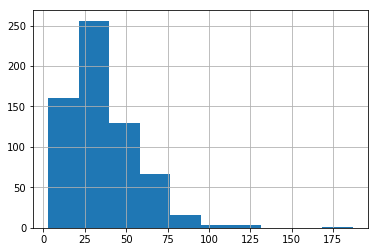

In [27]:
home_tracts_to_users_df[USER_COUNT].hist()
home_tracts_to_users_df[USER_COUNT].describe()

,geometry,Geography,Estimate; Total,Margin of Error; Total,LBS user count
TRACT,,,,,
25025070101,POLYGON ((-71.05043458809909 42.35485467288492...,"Census Tract 701.01, Suffolk County, Massachus...",6496.0,470.0,187.0
25017333600,POLYGON ((-71.12099961914964 42.50253269803456...,"Census Tract 3336, Middlesex County, Massachus...",7912.0,532.0,131.0
25017321400,POLYGON ((-71.57500775843006 42.34123765269062...,"Census Tract 3214, Middlesex County, Massachus...",3232.0,204.0,130.0
25025060600,POLYGON ((-71.03340458233104 42.35087267283699...,"Census Tract 606, Suffolk County, Massachusetts",3219.0,292.0,114.0
25017325100,POLYGON ((-71.51145975225228 42.56939469827711...,"Census Tract 3251, Middlesex County, Massachus...",8014.0,18.0,108.0


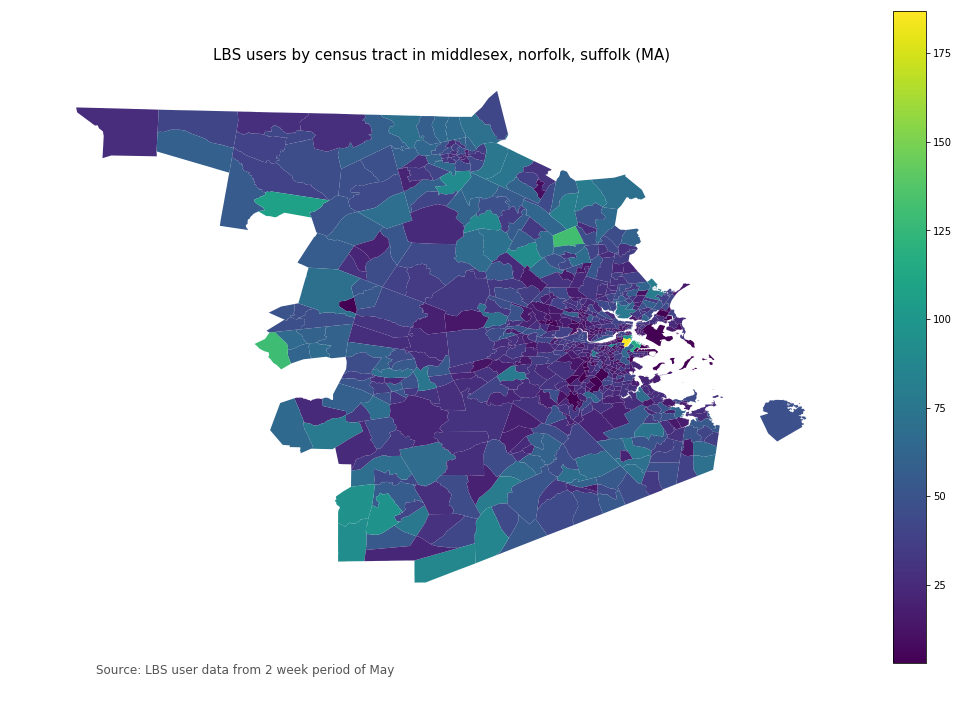

In [28]:
# Now map LBS inferred homes data as population data...
# merge the LBS data with the previously merged data

home_tracts_to_users_df[TRACT] = home_tracts_to_users_df.astype({TRACT: 'int64'})[TRACT]
merged_tracts_acs_lbs_data_shapefile = merged_tracts_data_shapefile.join(home_tracts_to_users_df.set_index(TRACT))

# Make the map!
fig, ax = plt.subplots(1, figsize=(18, 12))
merged_tracts_acs_lbs_data_shapefile.plot(column=USER_COUNT, ax=ax, legend=True) #, cmap='Blues', linewidth=0.8, edgecolor='0.8')
ax.axis('off')
title = 'LBS users by census tract in %s (MA)' % ', '.join(counties)
ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'})
# create an annotation for the data source
annotation = 'Source: LBS user data from 2 week period of May'
ax.annotate(annotation, xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

merged_tracts_acs_lbs_data_shapefile.sort_values(by=USER_COUNT, ascending=False).head()

In [29]:
merged_tracts_acs_lbs_data_shapefile[USER_COUNT].describe()

count    637.000000
mean      35.593407
std       20.630460
min        3.000000
25%       21.000000
50%       31.000000
75%       46.000000
max      187.000000
Name: LBS user count, dtype: float64

## LBS user count data notes

What are these tracts with so many users?
- Tract 25025981300: The airport!  Took it out!
- Tract 25025070101 covers the financial district, South Station, Downtown crossing
- Tract 25025030300 covers City Hall, Haymarket, Aquarium harbor area & Fanuil Hall -- where people go to bars at night!!
- Tract 25017333600 is legitimately populous

In [30]:
merged_tracts_acs_lbs_df = pd.DataFrame(data={
    USER_COUNT: merged_tracts_acs_lbs_data_shapefile[USER_COUNT],
    ACS_POPULATION_ESTIMATE: merged_tracts_acs_lbs_data_shapefile[ACS_POPULATION_ESTIMATE]
})
# Drop the tracts where LBS user count is 0
merged_tracts_acs_lbs_df = merged_tracts_acs_lbs_df[merged_tracts_acs_lbs_df[USER_COUNT] > 0]
print(merged_tracts_acs_lbs_df.shape)

merged_tracts_acs_lbs_df.head()

(637, 2)


,LBS user count,Estimate; Total
TRACT,,
25021418003,36.0,2793.0
25021417701,52.0,5380.0
25021417702,15.0,2774.0
25021418102,23.0,3300.0
25021418004,45.0,4377.0


## ACS estimates vs LBS users : Correlation and plots

In [63]:
def plot_lbs_user_count_vs_acs_estimates(df):
    df.plot(
        x=USER_COUNT,
        y=ACS_POPULATION_ESTIMATE,
        style='o',
        cmap='Blues',
        alpha=0.8,
        figsize=(10, 8))
    plt.title('ACS population estimates vs LBS users for census tracts')
    plt.xlabel('LBS user count', fontsize=12)
    plt.ylabel('ACS population estimate', fontsize=12)
    plt.show()
    print('correlation:', df.corr())

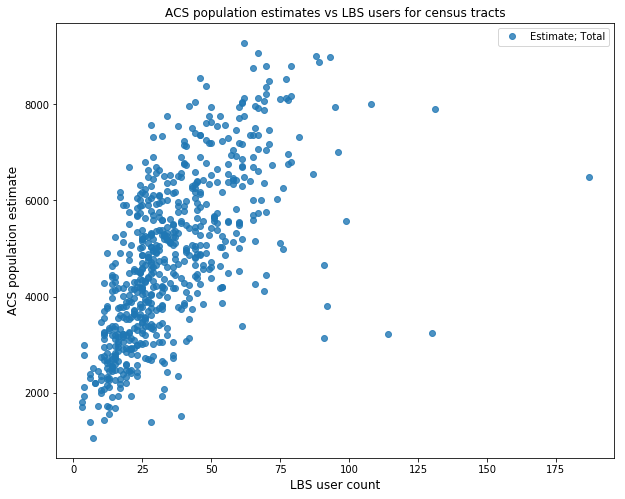

correlation:                  LBS user count  Estimate; Total
LBS user count         1.000000         0.643161
Estimate; Total        0.643161         1.000000


,LBS user count,Estimate; Total
count,637.000000,637.000000
mean,35.593407,4797.601256
std,20.630460,1693.139485
min,3.000000,1054.000000
25%,21.000000,3431.000000
50%,31.000000,4725.000000
75%,46.000000,5985.000000
max,187.000000,9286.000000


In [64]:
plot_lbs_user_count_vs_acs_estimates(merged_tracts_acs_lbs_df)
merged_tracts_acs_lbs_df.describe()

Dropping just a couple of outlier census tracts greatly increases the correlation.

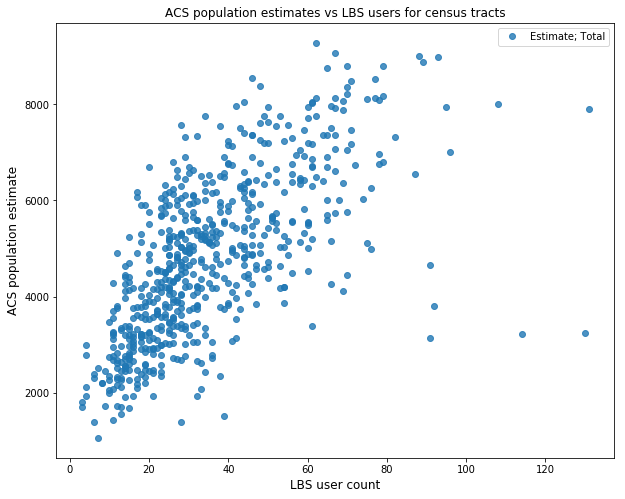

correlation:                  LBS user count  Estimate; Total
LBS user count         1.000000         0.663919
Estimate; Total        0.663919         1.000000


,LBS user count,Estimate; Total
count,635.000000,635.000000
mean,35.255118,4793.691339
std,19.604716,1694.175031
min,3.000000,1054.000000
25%,21.000000,3421.000000
50%,30.000000,4712.000000
75%,46.000000,5984.500000
max,131.000000,9286.000000


In [67]:
# Now drop the rows where people party and the LBS user numbers huge ...
# 25025070101 (users=264) covers the financial district, South Station, Downtown crossing
# 25025030300 covers Haymarket area
plot_lbs_user_count_vs_acs_estimates(merged_tracts_acs_lbs_df.drop([25025070101, 25025030300]))
merged_tracts_acs_lbs_df.drop([25025070101, 25025030300]).describe()

# Map Making

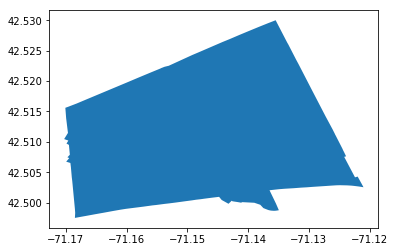

In [455]:
# Choose a home census tract.  Map that tract.

home_tract_choice = 25017333600
tract_shape = merged_tracts_data_shapefile.loc[[home_tract_choice]]
tract_shape.plot()

In [ ]:
# Get subset of data for just users whose inferred home tracts are the chosen home tract

def get_tract_dwell_data_for_users_with_home(df, user_homes_df, home_tract):
    users_with_chosen_home_tract = user_homes_df[user_homes_df[HOME_TRACT] == home_tract][DEVICE_ID]
    users_with_chosen_home_tract_data_df = df[df[DEVICE_ID].isin(users_with_chosen_home_tract)]
    return users_with_chosen_home_tract_data_df[[TIMESTAMP, DEVICE_ID, DWELLTIME, TRACT]]

users_with_chosen_home_tract_data_df = get_tract_dwell_data_for_users_with_home(df, user_homes_df, home_tract_choice)

In [457]:
DAY_OF_WEEK = 'day of week'


def get_day_of_week(tstmp):
    tstmp = parser.parse(str(tstmp))
    return tstmp.weekday()

def weekend_data_df(df):
    """Restricts data to just weekend data."""
    df[DAY_OF_WEEK] = df[TIMESTAMP].apply(get_day_of_week)
    return df[df[DAY_OF_WEEK] >= 5].drop(DAY_OF_WEEK, axis=1)
    
def weekday_data_df(df):
    """Restricts data to just weekend data."""
    df[DAY_OF_WEEK] = df[TIMESTAMP].apply(get_day_of_week)
    return df[df[DAY_OF_WEEK] < 5].drop(DAY_OF_WEEK, axis=1)


In [ ]:
users_with_chosen_home_tract_weekday_data_df = weekday_data_df(users_with_chosen_home_tract_data_df)

In [459]:
# Make the aggregate map
# tract, aggregate dwelltime

AGGREGATE_DWELLTIME = 'aggr. dwelltime'
AVG_DWELLTIME_PER_USER = 'avg. dwelltime per user'

def aggregate_tract_to_dwells_df(df):
    """Returns dataframe mapping tracts to the aggregate, and avg dwelltime for that tract."""
    # Create dictionary, then dataframe
    tracts_to_dwelltime_dict = {} # {TRACT: aggregate dwelltime}
    tracts = df[TRACT].unique()
    for tract in tracts:
        tracts_to_dwelltime_dict[tract] = df[df[TRACT] == tract][DWELLTIME].sum()

    users_count = df[DEVICE_ID].nunique()
    # Transform that dictiontary into a dataframe
    df = pd.DataFrame.from_dict({TRACT: list(tracts_to_dwelltime_dict.keys()),
                                AGGREGATE_DWELLTIME: list(tracts_to_dwelltime_dict.values())})
    df[AVG_DWELLTIME_PER_USER] = df[AGGREGATE_DWELLTIME]/users_count
    return df


/Users/aberke/anaconda3/lib/python3.7/site-packages/mapclassify/classifiers.py:96: UserWarning: Warning: setting k to 7
  Warn('Warning: setting k to %d' % k_q, UserWarning)


,geometry,aggr. dwelltime,avg. dwelltime per user
TRACT,,,
25017317203,"POLYGON ((-71.3517887021048 42.62272571364048,...",95.98,95.98
25017333600,POLYGON ((-71.12099961914964 42.50253269803456...,75.19,75.19
25017358300,POLYGON ((-71.22225264906261 42.43422768208396...,64.23,64.23
25017316202,POLYGON ((-71.20503264985798 42.54448170381578...,56.34,56.34
25017358600,POLYGON ((-71.23004765169438 42.45042868534473...,50.62,50.62


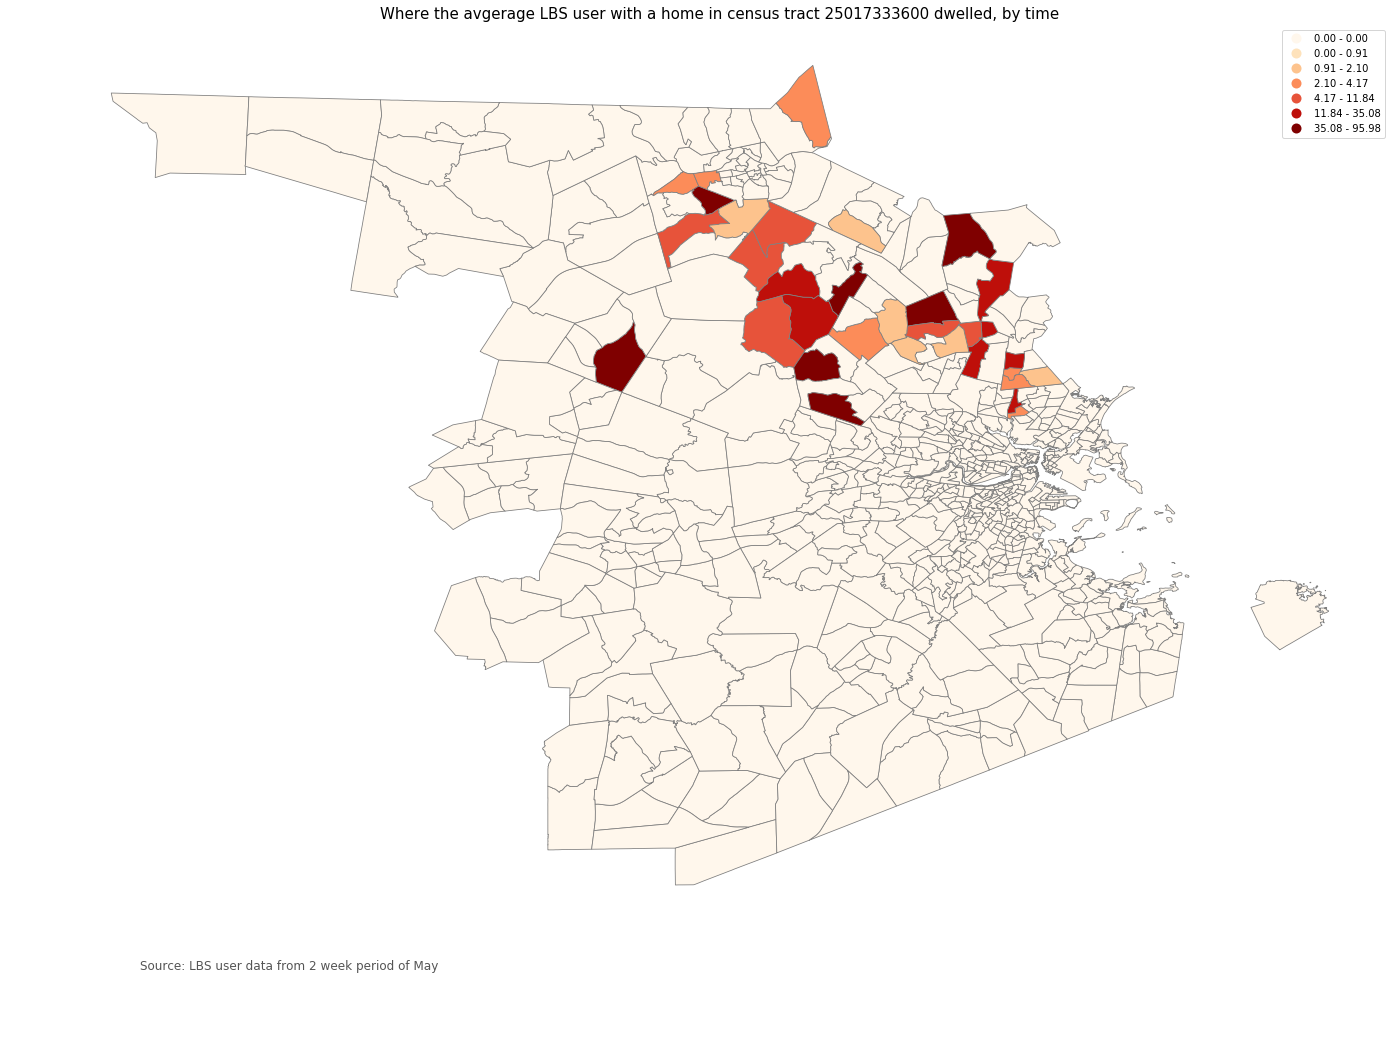

In [460]:
# Map it!


def map_aggregate_dwelltime(dwell_data_df, title=title, column=AVG_DWELLTIME_PER_USER):
    dwell_data_shapefile = tracts_shapefile.set_index(TRACT).join(dwell_data_df.set_index(TRACT)).fillna(0)
    fig, ax = plt.subplots(1, figsize=(24, 18))
    dwell_data_shapefile.plot(column=column,
                                ax=ax,
                                cmap='OrRd',
#                                 cmap='Blues',
#                                 scheme='equal_interval',
                                scheme='quantiles',
                                k=100,
                                linewidth=0.8, edgecolor='0.5',
                                legend=True)
    ax.axis('off')
    title = title if title else ''
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'})
    annotation = 'Source: LBS user data from 2 week period of May'
    ax.annotate(annotation, xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    return dwell_data_shapefile
    
tracts_to_weekday_dwelltime_shapefile = map_aggregate_dwelltime(tracts_to_weekday_dwelltime_df,
                                                                column=AVG_DWELLTIME_PER_USER,
                                                                title='Where the avgerage LBS user with a home in census tract %s dwelled, by time' % home_tract_choice
                                                               )
tracts_to_weekday_dwelltime_shapefile.sort_values(by=AGGREGATE_DWELLTIME, ascending=False).head()


,geometry,aggr. dwelltime,avg. dwelltime per user
TRACT,,,
25021418003,POLYGON ((-71.00721256587961 42.23014165019458...,0.00,0.000000
25021417701,POLYGON ((-71.00345056634727 42.26050865653624...,0.00,0.000000
25021417702,POLYGON ((-70.98695456210277 42.26423765714259...,0.00,0.000000
25021418102,POLYGON ((-71.01081056769503 42.24440865265075...,0.00,0.000000
25021418004,POLYGON ((-71.00700056748178 42.24409865285512...,0.00,0.000000
25021412300,POLYGON ((-71.18209062351946 42.22760464412915...,80.28,0.787059
25021412200,"POLYGON ((-71.1860716250562 42.22863864411771,...",0.00,0.000000
25021404400,"POLYGON ((-71.2694086560499 42.29084565314511,...",0.00,0.000000
25021404301,POLYGON ((-71.29648966613524 42.30615065566531...,0.00,0.000000


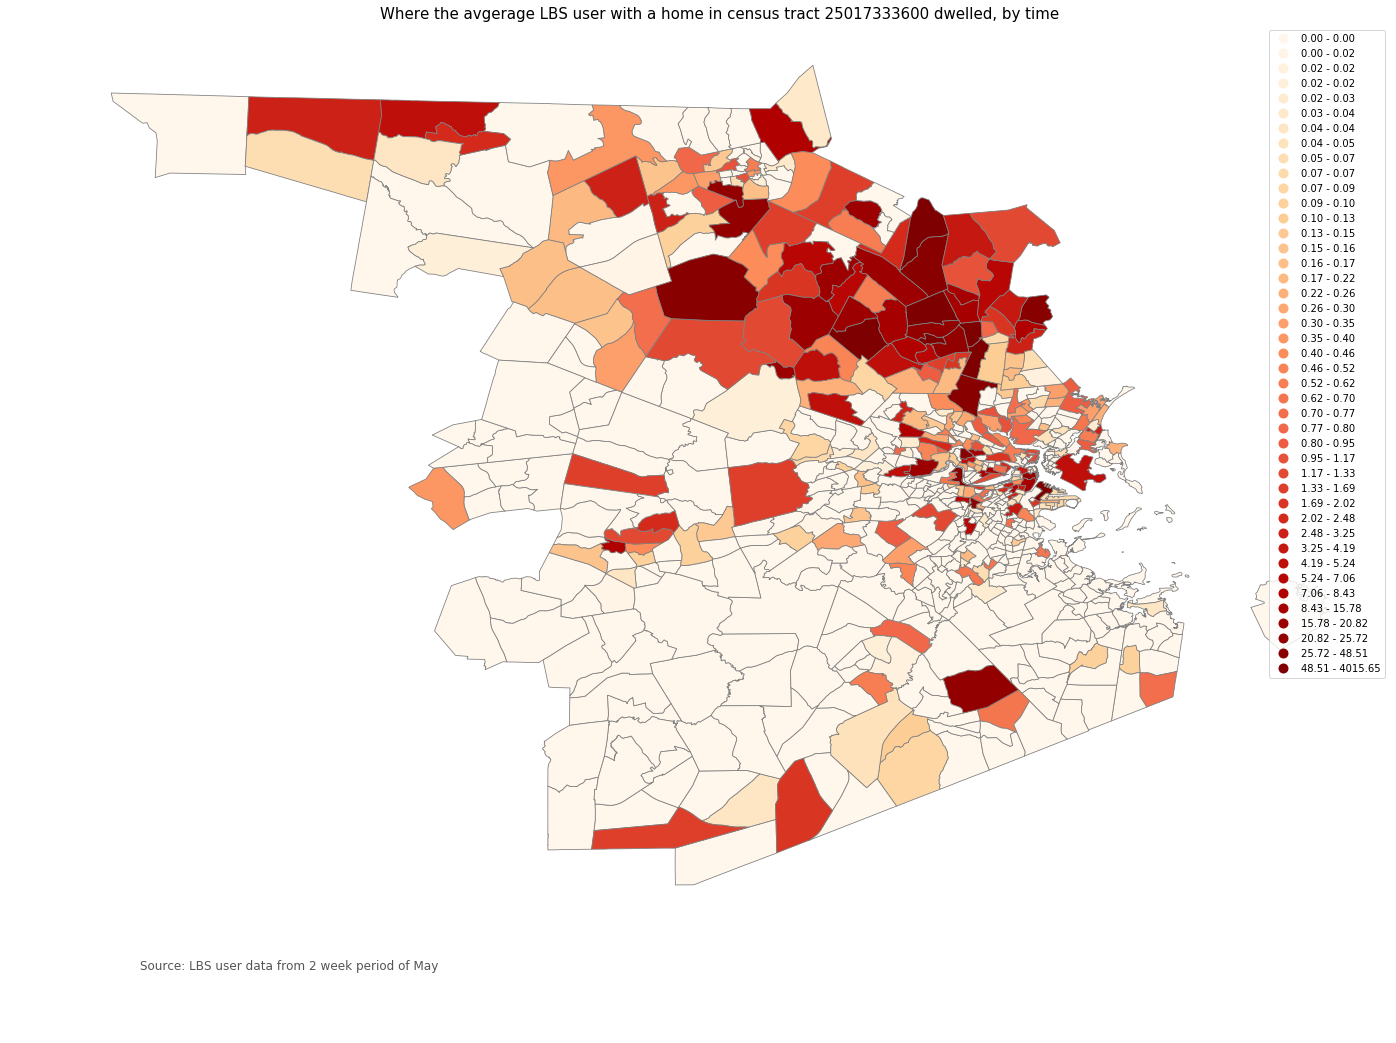

In [461]:
# Restrict data to users with chosen home census tract
users_with_chosen_home_tract_data_df = get_tract_dwell_data_for_users_with_home(df, user_homes_df, home_tract_choice)

# Restrict data to weekday / weekend
users_with_chosen_home_tract_weekday_data_df = weekday_data_df(users_with_chosen_home_tract_data_df)


# Make DF mapping tract to aggregate weekend/weekday dwelltime for all users for chosen home census tract
tracts_to_weekday_dwelltime_df = aggregate_tract_to_dwells_df(users_with_chosen_home_tract_weekday_data_df)
# Make Assumptions about the data: The chosen home tract should have the highest aggregate dwelltime
assert(tracts_to_weekday_dwelltime_df.sort_values(by=[AGGREGATE_DWELLTIME], ascending=False).iloc[0][TRACT] == home_tract_choice)

# Plot it
map_aggregate_dwelltime(tracts_to_weekday_dwelltime_df,
                    column=AVG_DWELLTIME_PER_USER,
                    title='Where the avgerage LBS user with a home in census tract %s dwelled, by time' % home_tract_choice
                    )



In [ ]:
# Plot the aggregate dwelltime in each tract for each user that made up the above aggregate total.
user_ids = users_with_chosen_home_tract_data_df[DEVICE_ID].unique()
for user_id in user_ids:
    user_df = users_with_chosen_home_tract_data_df[users_with_chosen_home_tract_data_df[DEVICE_ID] == user_id]
    user_weekday_data_df = weekday_data_df(user_df)
    user_tracts_to_weekday_dwelltime_df = aggregate_tract_to_dwells_df(user_weekday_data_df)
    map_aggregate_dwelltime(user_tracts_to_weekday_dwelltime_df,
                    title='Where an LBS user with a home in census tract %s dwelled, by time' % home_tract_choice
                    )


/Users/aberke/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.1, 0.08, 'Source: LBS user data from 2 week period of May')

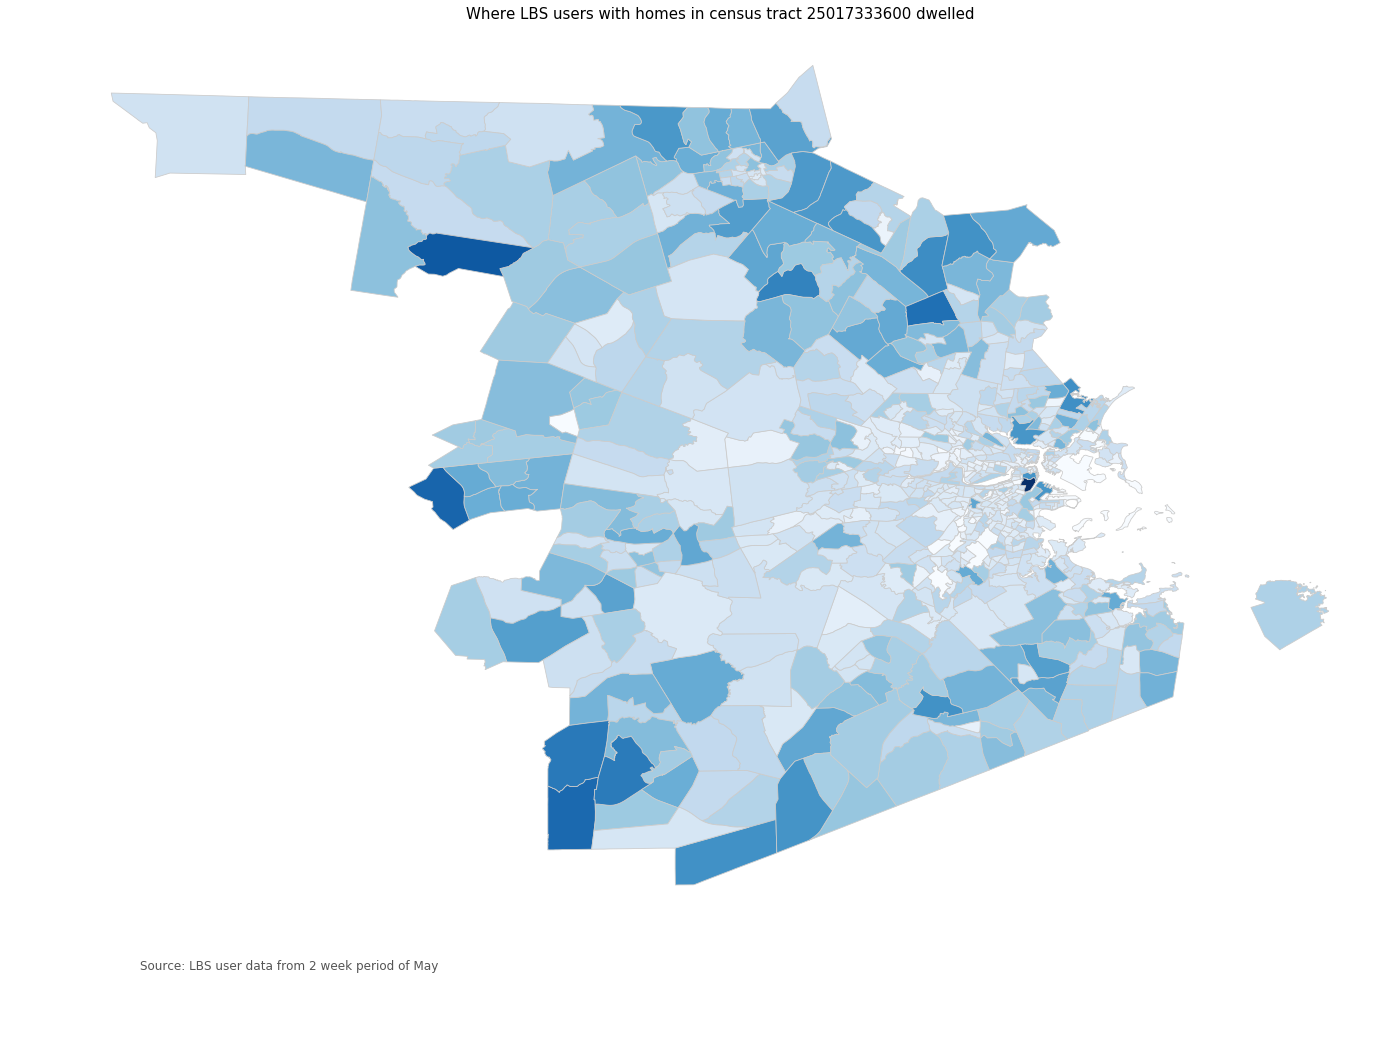

In [400]:
# Make the map!
fig, ax = plt.subplots(1, figsize=(24, 18))
merged_tracts_acs_lbs_data_shapefile.plot(column=USER_COUNT, ax=ax, cmap='Blues', linewidth=0.8, edgecolor='0.8')
ax.axis('off')
title = 'Where LBS users with homes in census tract %s dwelled' % home_tract_choice
ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '2'})
annotation = 'Source: LBS user data from 2 week period of May'
ax.annotate(annotation, xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
